# Section 20. The Euler method (cont'd)

from Chapter 2. Numerical Differentail Equation Methods in Butcher "Numerical methods for ordinary differential equations," 2nd ed., Wiley, 2008.

掲載されている図をできるだけ単純に作ってみたい．

$$
\newcommand{\bv}[1]{\pmb{#1}}
\newcommand{\df}[2]{\frac{d #1}{d #2}}
\newcommand{\pf}[2]{\frac{\partial #1}{\partial #2}}
%
\newcommand{\pr}[1]{\!\left( #1 \right)}
%
\newcommand{\pmat}[1]{\begin{pmatrix} #1 \end{pmatrix}} % \pmat{1 & 2 \\ 3 & 4}
\newcommand{\mat}[1]{\left( \begin{matrix} #1 \end{matrix} \right)}
$$

In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from numba import njit

## §201. Some numerical experiments

#### 例2

無次元化した，太陽と惑星の運動方程式(導出などは後々追加したい)：
$$
\renewcommand{reprA}{(y_1^2 + y_2^2)^\frac{3}{2}}
\begin{align*}
\df{y_1}{x} &= y_3 \\
\df{y_2}{x} &= y_4 \\
\df{y_3}{x} &= - \frac{y_1}{\reprA} \\
\df{y_4}{x} &= - \frac{y_2}{\reprA} 
\end{align*}
$$

$y_1, y_2$が太陽を中心とした直交座標系での惑星の位置．$y_3, y_4$がそれぞれ$y_1, y_2$方向の速度だというのを表すのが上の2本の式．下の2本の式は，速度の微分(加速度)と引力の関係を表す運動方程式．ただし太陽への惑星の影響は無視できるほど太陽が重いと仮定している．


離心率を$e$として，初期値を
$$
\bv{y}(0) = \pmat{1-e \\ 0 \\ 0 \\ \sqrt{\frac{1+e}{1-e}} }
$$
とするとき，$x=\pi$における厳密解 (ということは$x$は時刻ではなく太陽を中心とした極座標表示での近日点からの角度なのか？このスケールでは時刻と角度が同じになるということなのか？)
$$
\bv{y}(\pi) = \pmat{-1-e \\ 0 \\ 0 \\ \sqrt{-\frac{1-e}{1+e}} }
$$
とのerrorを，stepsize $h = \frac{1}{n}$ ($n$はステップ数) を変えてプロットしたのが次の図．

離心率$e=0$のときに円軌道，$0<e<1$のときに楕円軌道となる．$e=\frac{1}{2}$の方が，$e=\frac{3}{4}$より円軌道に近い．

軌道の厳密解は(導出は後々追加)，
$$
r(\phi) = \frac{C}{1+e \cos \phi}
$$
ここで，初期値 $r(0) = \frac{C}{1+e} = 1-e$ より，$C = 1-e^2$．

#### Euler method with constant stepsize
$$
\bv{y}(x_n) = \bv{y}(x_{n-1}) + h\bv{y}'(x_{n-1})
$$
(ただしstepsize $h = x_n - x_{n-1} = \frac{x_{max} - x_{min}}{N}$. $N$はステップの総数)で $x_{min} = x_0 = 0$ から $x_{max} = x_{N} = \pi$ まで計算する．

In [24]:
class Test1:
    def __init__(self, xmin=0, xmax=np.pi, n_steps_total=200, eccentricity=0.0):
        self.xmin = xmin
        self.xmax = xmax
        self.n_steps_total = n_steps_total
        self.eccentricity = eccentricity
    
    def run(self):
        e = self.eccentricity
        xmin, xmax, n_steps_total = self.xmin, self.xmax, self.n_steps_total
        
        xs = np.linspace(xmin, xmax, n_steps_total, dtype=np.float64)
        y0 = np.array([1.-e, 0., 0., np.sqrt((1.+e)/(1.-e))], dtype=np.float64)
        ys = self._run(xs, y0, self._f)
        
        self.xs = xs
        self.ys = ys
        
        return self
    
    @staticmethod
    @njit
    def _run(xs, y0, _f):
        ys = np.zeros(shape=(len(xs), len(y0)), dtype=np.float64)
        ys[0,:] = y0[:]
        
        for i in range(1, len(xs)):
            h = xs[i] - xs[i-1]
            dydx = _f(xs[i-1], ys[i-1,:])
            ys[i,:] = ys[i-1,:] + h*dydx[:]
            
        return ys
    
    @staticmethod
    @njit
    def _f(x, y):
        C = (y[0]**2 + y[1]**2)**(-3./2.)
        dydx = np.array([
             y[2],
             y[3],
            -y[0]*C,
            -y[1]*C,
        ], dtype=np.float64)
        return dydx

In [25]:
test1a = Test1(n_steps_total=200, eccentricity=0.)
%time test1a.run()

test1b = Test1(n_steps_total=20000, eccentricity=0.)
%time test1b.run()

Wall time: 545 ms
Wall time: 4.99 ms


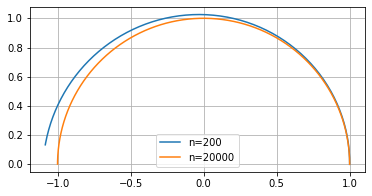

In [26]:
fig, ax = plt.subplots()
for test in [test1a, test1b]:
    ax.plot(test.ys[:,0], test.ys[:,1], label=f"n={test.n_steps_total}")

ax.legend()
ax.grid(which='both')
ax.set_aspect('equal')

In [27]:
def make_tests(eccentricity, n_steps_totals=[2e2, 2e3, 2e4, 2e5]):
    tests = []
    for n_steps_total in n_steps_totals:
        tests.append( Test1(n_steps_total=int(n_steps_total), eccentricity=eccentricity).run() )
    return tests

tests_a = make_tests(eccentricity=0.)
tests_b = make_tests(eccentricity=0.5)
tests_c = make_tests(eccentricity=0.75)

C:\Users\akamine\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


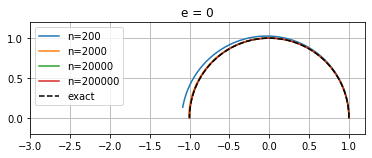

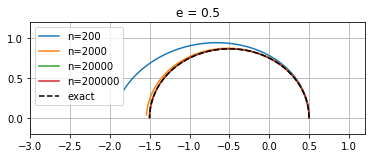

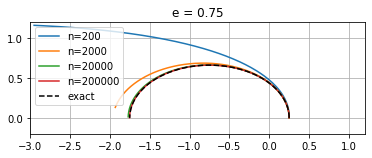

In [28]:
for tests, title in [(tests_a, "e = 0"), (tests_b, "e = 0.5"), (tests_c, "e = 0.75")]:
    fig, ax = plt.subplots()
    for test in tests:
        ax.plot(test.ys[:,0], test.ys[:,1], label=f"n={test.n_steps_total}")

    e = test.eccentricity
    phis = np.linspace(0, np.pi, 200)
    rs = (1.-e**2) / (1.+e*np.cos(phis))
    ys1, ys2 = rs*np.cos(phis), rs*np.sin(phis)
    ax.plot(ys1, ys2, 'k--', label='exact')
    
    ax.set_title(title)
    ax.set_xlim(-3, 1.2)
    ax.set_ylim(-0.2, 1.2)
    ax.legend()
    ax.grid(which='both')
    ax.set_aspect('equal')

離心率 $e=0$ のとき(円軌道)のときは，ステップ数 2000で厳密解に重なっている．
離心率が大きくなると，よりステップ数を増やさないと良い解が得られないことが見てわかる．

In [29]:
plot_data = []
for tests in [tests_a, tests_b, tests_c]:
    e = tests[0].eccentricity
    y_exact = np.array([-1.-e, 0., 0., -np.sqrt((1.-e)/(1.+e))])
    
    ns, errors = [], []
    for test in tests:
        error = np.linalg.norm(test.ys[-1,:] - y_exact)
        ns.append(test.n_steps_total)
        errors.append(error)
    plot_data.append(dict(
        label = f'e = {e:.2f}',
        ns = np.array(ns),
        errors = np.array(errors),
    ))

Text(0, 0.5, 'Error')

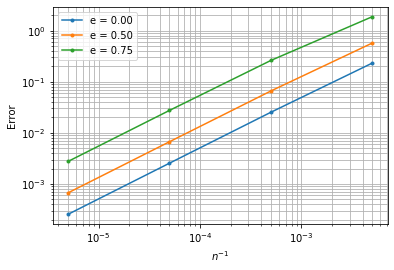

In [30]:
fig, ax = plt.subplots()
for data1 in plot_data:
    ax.loglog(1./data1['ns'], data1['errors'], '.-', label=data1['label'])
ax.legend()
ax.grid(which='both')
ax.set_xlabel(r'$n^{-1}$')
ax.set_ylabel('Error')


### §202 Calculations with stepsize control

(本の説明が不親切だと思う...)

In [31]:
class Test2(Test1):
    def __init__(self, n_subintervals=10, **kwargs):
        super().__init__(**kwargs)
        self.n_subintervals = n_subintervals
    
    def run(self):
        e = self.eccentricity
        xmin, xmax, n_steps_total = self.xmin, self.xmax, self.n_steps_total
        n_subintervals = self.n_subintervals
        
        xs_pre = np.linspace(xmin, xmax, n_subintervals+1, dtype=np.float64)
        
        y0 = np.array([1.-e, 0., 0., np.sqrt((1.+e)/(1.-e))], dtype=np.float64)
        ys_pre, errors = self._run(xs_pre, y0, self._f)
        
        n_steps_in_interval = (n_steps_total * errors / np.sum(errors)).astype(int)
        n_steps_in_interval[1:] += 1
        
        n_steps_total_exact = np.sum(n_steps_in_interval)+1
        xs = np.zeros(shape=(n_steps_total_exact,), dtype=np.float64)
        i_start_of_interval = np.cumsum(n_steps_in_interval)
        
#         print(n_steps_total)
#         print(n_steps_in_interval)
#         print(n_steps_total_exact)
#         print(i_start_of_interval)
        
        for i in range(1, n_subintervals+1):
            h = xs_pre[i] - xs_pre[i-1]
            n_steps1 = n_steps_in_interval[i]
            i1 = i_start_of_interval[i-1]
            i2 = i1 + n_steps1
#             print(i, n_steps1, i1, i2, (i_start_of_interval[i-1], i_start_of_interval[i]))
            xs[i1:i2] = np.linspace(xs_pre[i-1], xs_pre[i], n_steps1, endpoint=False)
        xs[-1] = xs_pre[-1]
#         print(xs)
        
        ys, _ = self._run(xs, y0, self._f)
        
        
        self.n_steps_in_interval = n_steps_in_interval
        self.n_steps_total_exact = n_steps_total_exact
        self.i_start_of_interval = i_start_of_interval
        
        self.xs = xs
        self.ys = ys
        
        return self
    
    @staticmethod
    @njit
    def _run(xs, y0, _f):
        ys = np.zeros(shape=(len(xs), len(y0)), dtype=np.float64)
        ys[0,:] = y0[:]
        
        errors = np.zeros_like(xs, dtype=np.float64)
        
        for i in range(1, len(xs)):
            h = xs[i] - xs[i-1]
            dydx = _f(xs[i-1], ys[i-1,:])
            ys[i,:] = ys[i-1,:] + h*dydx[:]
            
            dydx_new = _f(xs[i], ys[i,:])
            errors[i] = np.linalg.norm(0.5*h*( dydx - dydx_new ))
            
        return ys, errors

In [32]:
test1a = Test1(n_steps_total=200, eccentricity=0.75).run()
test1b = Test1(n_steps_total=200000, eccentricity=0.75).run()

test2a = Test2(n_subintervals=50, n_steps_total=165, eccentricity=0.75).run()
print(test2a.n_steps_in_interval)
print(test2a.xs)

[ 0 66 43 23 12  7  5  3  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1]
[0.00000000e+00 9.51997774e-04 1.90399555e-03 2.85599332e-03
 3.80799110e-03 4.75998887e-03 5.71198664e-03 6.66398442e-03
 7.61598219e-03 8.56797996e-03 9.51997774e-03 1.04719755e-02
 1.14239733e-02 1.23759711e-02 1.33279688e-02 1.42799666e-02
 1.52319644e-02 1.61839622e-02 1.71359599e-02 1.80879577e-02
 1.90399555e-02 1.99919533e-02 2.09439510e-02 2.18959488e-02
 2.28479466e-02 2.37999443e-02 2.47519421e-02 2.57039399e-02
 2.66559377e-02 2.76079354e-02 2.85599332e-02 2.95119310e-02
 3.04639288e-02 3.14159265e-02 3.23679243e-02 3.33199221e-02
 3.42719199e-02 3.52239176e-02 3.61759154e-02 3.71279132e-02
 3.80799110e-02 3.90319087e-02 3.99839065e-02 4.09359043e-02
 4.18879020e-02 4.28398998e-02 4.37918976e-02 4.47438954e-02
 4.56958931e-02 4.66478909e-02 4.75998887e-02 4.85518865e-02
 4.95038842e-02 5.04558820e-02 5.14078798e-02 5.23

C:\Users\akamine\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


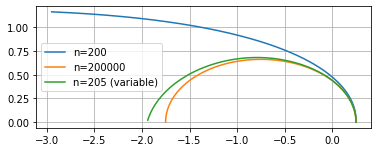

In [33]:
fig, ax = plt.subplots()
for test in [test1a, test1b]:
    ax.plot(test.ys[:,0], test.ys[:,1], label=f"n={test.n_steps_total}")

ax.plot(test2a.ys[:,0], test2a.ys[:,1], label=f"n={test2a.n_steps_total_exact} (variable)")
    
ax.legend()
ax.grid(which='both')
ax.set_aspect('equal')

In [34]:
def make_tests2(eccentricity, n_steps_totals=[2e2, 2e3, 2e4, 2e5]):
    tests = []
    for n_steps_total in n_steps_totals:
        tests.append( Test2(
            n_steps_total=int(n_steps_total), 
            n_subintervals=int(n_steps_total/2),
            eccentricity=eccentricity
        ).run() )
    return tests

tests2_a = make_tests2(eccentricity=0.)
tests2_b = make_tests2(eccentricity=0.5)
tests2_c = make_tests2(eccentricity=0.75)

In [35]:
plot_data2 = []
for tests in [tests2_a, tests2_b, tests2_c]:
    e = tests[0].eccentricity
    y_exact = np.array([-1.-e, 0., 0., -np.sqrt((1.-e)/(1.+e))])
    
    ns, errors = [], []
    for test in tests:
        error = np.linalg.norm(test.ys[-1,:] - y_exact)
        ns.append(test.n_steps_total_exact)
        errors.append(error)
    plot_data2.append(dict(
        label = f'e = {e:.2f} (variable)',
        ns = np.array(ns),
        errors = np.array(errors),
    ))

[   257   2583  25851 258531]
[   259   2526  25199 251911]
[   280   2777  27679 276653]


Text(0, 0.5, 'Error')

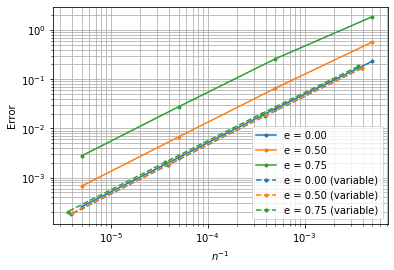

In [36]:
fig, ax = plt.subplots()
for i_data, data1 in enumerate(plot_data):
    ax.loglog(1./data1['ns'], data1['errors'], '.-', c=f'C{i_data}', label=data1['label'])
for i_data, data2 in enumerate(plot_data2):
    print(data2['ns'])
    ax.loglog(1./data2['ns'], data2['errors'], '.--', c=f'C{i_data}', label=data2['label'])
ax.legend()
ax.grid(which='both')
ax.set_xlabel(r'$n^{-1}$')
ax.set_ylabel('Error')

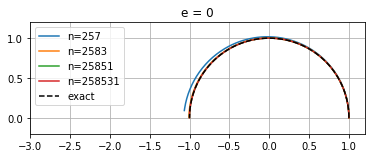

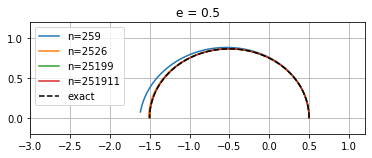

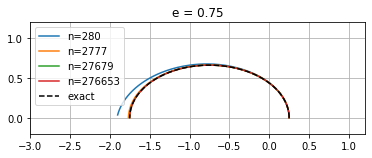

In [37]:
for tests, title in [(tests2_a, "e = 0"), (tests2_b, "e = 0.5"), (tests2_c, "e = 0.75")]:
    fig, ax = plt.subplots()
    for test in tests:
        ax.plot(test.ys[:,0], test.ys[:,1], label=f"n={test.n_steps_total_exact}")

    e = test.eccentricity
    phis = np.linspace(0, np.pi, 200)
    rs = (1.-e**2) / (1.+e*np.cos(phis))
    ys1, ys2 = rs*np.cos(phis), rs*np.sin(phis)
    ax.plot(ys1, ys2, 'k--', label='exact')
    
    ax.set_title(title)
    ax.set_xlim(-3, 1.2)
    ax.set_ylim(-0.2, 1.2)
    ax.legend()
    ax.grid(which='both')
    ax.set_aspect('equal')

Text(0, 0.5, 'h')

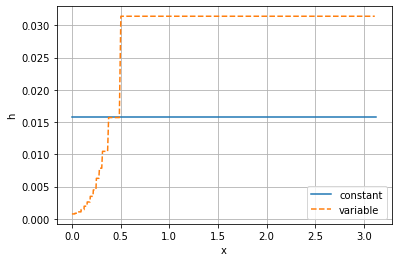

In [38]:
fig, ax = plt.subplots()
ax.plot(tests_c[0].xs[:-1], np.diff(tests_c[0].xs), '-', label='constant')
ax.plot(tests2_c[0].xs[:-1], np.diff(tests2_c[0].xs), '--', label='variable')
ax.legend()
ax.grid(which='both')
ax.set_xlabel('x')
ax.set_ylabel('h')